In [10]:
import os
import torch
import matplotlib.pyplot as plt

from datetime import datetime
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, CenterCrop
from tqdm import tqdm

from models.lenet import LeNet

### Datasets

In [17]:
def load_mnist_dataset():
    training_data = datasets.MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )
    test_data = datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    return training_data, test_data

def load_fashionmnist_dataset():
    training_data = datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )
    test_data = datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    return training_data, test_data

def load_cifar10_dataset(transform = None):
    transform = ToTensor() if transform is None else transform
    training_data = datasets.CIFAR10(
        root='data',
        train=True,
        download=True,
        transform=transform
    )
    test_data = datasets.CIFAR10(
        root='data',
        train=False,
        download=True,
        transform=transform
    )
    return training_data, test_data

In [18]:
dataset_funcs = [load_mnist_dataset, load_fashionmnist_dataset, load_cifar10_dataset]

for i, get_data in enumerate(dataset_funcs):
    training_data, test_data = get_data()
    dataloader = DataLoader(training_data, batch_size=1)
    first_image, first_label = next(iter(dataloader))

    print('Dataset ', i)
    print('Input shape: ', first_image.shape)
    print('Class count: ', len(training_data.classes))

Dataset  0
Input shape:  torch.Size([1, 1, 28, 28])
Class count:  10
Dataset  1
Input shape:  torch.Size([1, 1, 28, 28])
Class count:  10
Files already downloaded and verified
Files already downloaded and verified
Dataset  2
Input shape:  torch.Size([1, 3, 32, 32])
Class count:  10


### Utility Functions

In [4]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: optim.Optimizer,
    num_epochs: int = 100,
    device: str = 'cpu',
) -> list[float]:
    model.train(True)
    loss_per_epoch = []
    pbar = tqdm(range(num_epochs))
    for _ in pbar:
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            pred = model(images)

            loss = model.loss(pred, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_per_epoch.append(total_loss)
        pbar.set_postfix({ "Epoch Loss": total_loss })
    return loss_per_epoch

def validate(model: nn.Module, dataloader: DataLoader, device: str = 'cpu'):
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = model.loss(pred, labels)
            total_loss += loss.item()
    print('Validation Loss: ', total_loss)

def plot_loss(num_epochs: int, loss: list[float]):
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(range(num_epochs), loss)
    plt.show()

def save_model(model: nn.Module, model_prefix: str = 'model_'):
    model_dir = 'saved_models'
    os.makedirs(model_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = f'{model_dir}/{model_prefix}{timestamp}'
    torch.save(model.state_dict(), model_path)

### LeNet

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyper parameters
BATCH_SIZE = 100
NUM_EPOCHS = 100

100%|██████████| 100/100 [23:41<00:00, 14.21s/it, Epoch Loss=0.089]


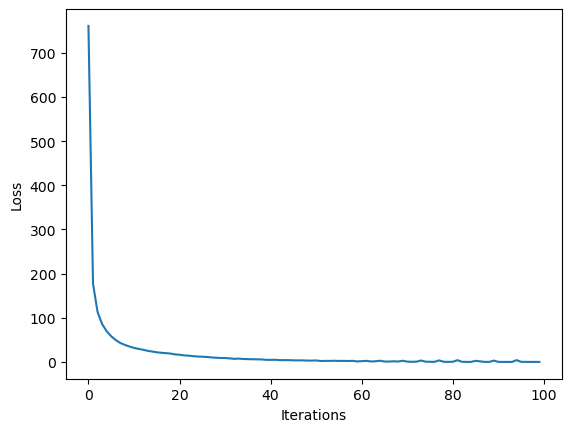

Validation Loss:  5.871229175420922


In [6]:
training_data, test_data = load_mnist_dataset()
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
model = LeNet(device=device)
optimizer = optim.Adam(model.parameters())
loss = train(model, training_loader, optimizer, num_epochs=NUM_EPOCHS, device=device)
plot_loss(NUM_EPOCHS, loss)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
validate(model, test_loader, device=device)

save_model(model, model_prefix='LeNet_MNIST_')

100%|██████████| 100/100 [19:29<00:00, 11.69s/it, Epoch Loss=91.7]


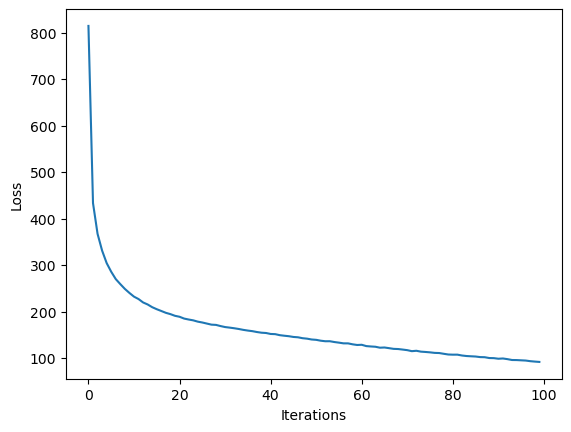

Validation Loss:  30.53490859270096


In [7]:
training_data, test_data = load_fashionmnist_dataset()
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
model = LeNet(device=device)
optimizer = optim.Adam(model.parameters())
loss = train(model, training_loader, optimizer, num_epochs=NUM_EPOCHS, device=device)
plot_loss(NUM_EPOCHS, loss)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
validate(model, test_loader, device=device)

save_model(model, model_prefix='LeNet_FashionMNIST_')

In [ ]:
transform = Compose([
    CenterCrop((28, 28)),
    ToTensor(),
])
training_data, test_data = load_cifar10_dataset(transform=transform)
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

model = LeNet(in_channels=3, device=device)
optimizer = optim.Adam(model.parameters())
loss = train(model, training_loader, optimizer, num_epochs=NUM_EPOCHS, device=device)
plot_loss(NUM_EPOCHS, loss)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
validate(model, test_loader, device=device)

save_model(model, model_prefix='LeNet_CIFAR10_')